In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [101]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df.isnull().sum(axis = 0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [106]:
from scipy import stats

# Start with some basic feature enginerring
df2 = df.copy()
df_test2 = df_test.copy()
joined = pd.concat([df2[['Age', 'Pclass']], df_test2[['Age', 'Pclass']]])
mean_ages_per_class = [int(joined[joined['Pclass'] == i]['Age'].mean()) for i in range(1, 4)]
def impute_age(row):
    if np.isnan(row['Age']):
        row['Age Known'] = 0
        row['Age'] = mean_ages_per_class[row['Pclass'] - 1]
    else:
        row['Age Known'] = 1
    return row
df2 = df2.apply(impute_age, axis=1)
df2['Fare Rank'] = df2['Fare'].rank()
df_test2 = df_test2.apply(impute_age, axis=1)
df_test2['Fare'] = df_test2['Fare'].fillna(df2['Fare'].mean())
df_test2['Fare Rank'] = df_test2['Fare'].rank()
def get_cabin_letter(cabin):
    if cabin is not None:
        cabin = str(cabin).split(' ')[-1]
        letter = cabin[0]
        letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
        if letter in letters:
            return letters.index(letter)
    return np.nan
def get_cabin_num(cabin):
    cabin = str(cabin).split(' ')[-1]
    if cabin != 'nan' and len(cabin) > 1:
        return int(cabin[1:])
    return None
df2['Cabin Letter'] = df2['Cabin'].apply(get_cabin_letter)
df2['Cabin Mates'] = df2.groupby('Cabin')['Cabin'].transform('count').fillna(0)
df2['Cabin'] = df2['Cabin'].fillna(0)
df2['Known Cabin Number'] = df2['Cabin'].apply(lambda x: 0 if x == 0 else 1)
df2['Sex'] = df2['Sex'].apply(lambda x: 0 if x == 'male' else 1)

df_test2['Cabin Letter'] = df_test2['Cabin'].apply(get_cabin_letter)
df_test2['Cabin Mates'] = df_test2.groupby('Cabin')['Cabin'].transform('count').fillna(0)
df_test2['Cabin'] = df_test2['Cabin'].fillna(0)
df_test2['Known Cabin Number'] = df_test2['Cabin'].apply(lambda x: 0 if x == 0 else 1)
df_test2['Sex'] = df_test2['Sex'].apply(lambda x: 0 if x == 'male' else 1)
df_test2.head()
joined_2 = pd.concat([df2[['Cabin Letter', 'Pclass', 'Fare']], df_test2[['Cabin Letter', 'Pclass', 'Fare']]])
g = joined_2.groupby(['Cabin Letter', 'Pclass'])['Fare']
cl_vals = df2['Cabin Letter'].dropna().unique()
def impute_cabin_letters(row):
    if row['Cabin Letter'] not in cl_vals:
        pc = row['Pclass']
        fare = row['Fare']
        best_cl = -1
        best_score = float('inf')
        for cl in cl_vals:
            try:
                mean_fare = g.get_group((cl, pc)).agg('mean')
                if (mean_fare - fare) ** 2 < best_score:
                    best_score = (mean_fare - fare) ** 2
                    best_cl = cl
            except:
                best_cl = best_cl
        row['Cabin Letter'] = best_cl
    return row
df2 = df2.apply(impute_cabin_letters, axis=1)
df_test2 = df_test2.apply(impute_cabin_letters, axis=1)
df2.groupby(['Embarked', 'Survived'])['PassengerId'].agg('count')

Embarked  Survived
C         0            75
          1            93
Q         0            47
          1            30
S         0           427
          1           217
Name: PassengerId, dtype: int64

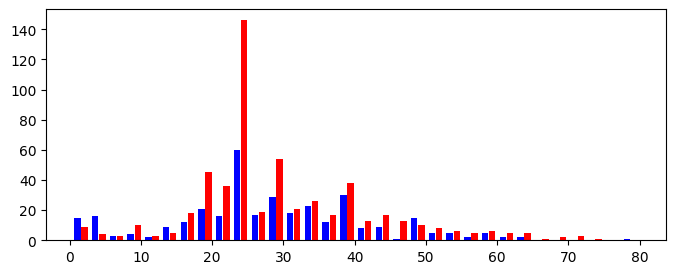

In [4]:
# Plot histograms
plt.figure(figsize=(8, 3))
plt.hist([df2[df2['Survived'] == 1]['Age'], df2[df2['Survived'] == 0]['Age']], 
         bins=32, width=.9, color=['blue', 'red']);

(0.0, 10.0)

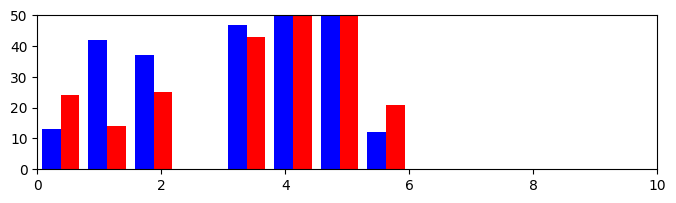

In [5]:
plt.figure(figsize=(8, 2))
plt.hist([df2[df2['Survived'] == 1]['Cabin Letter'], df2[df2['Survived'] == 0]['Cabin Letter']], 
         bins=8, width=.3, color=['blue', 'red']);
plt.ylim(0, 50)
plt.xlim(0, 10)

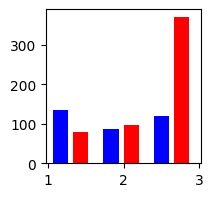

In [6]:
plt.figure(figsize=(2, 2))
plt.hist([df2[df2['Survived'] == 1]['Pclass'], df2[df2['Survived'] == 0]['Pclass']], 
         bins=3, width=.2, color=['blue', 'red']);

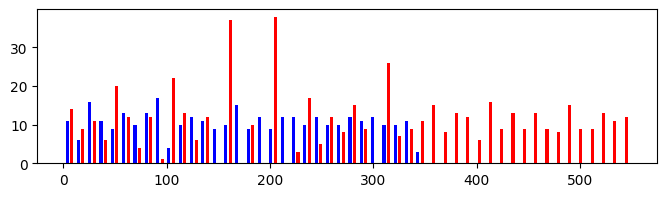

In [7]:
plt.figure(figsize=(8, 2))
plt.hist([df2[df2['Survived'] == 1]['Fare'].rank(), df2[df2['Survived'] == 0]['Fare'].rank()], 
         bins=50, width=3, color=['blue', 'red']);

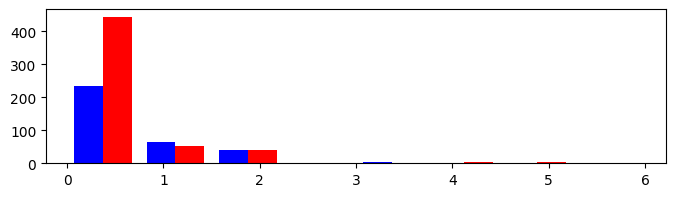

In [8]:
plt.figure(figsize=(8, 2))
plt.hist([df2[df2['Survived'] == 1]['Parch'], df2[df2['Survived'] == 0]['Parch']], 
         bins=8, width=.3, color=['blue', 'red']);
# plt.ylim(0, 130)

In [109]:
# Use One Hot Encoding to convert Cabin Letter and Embarkment 
df3 = df2.drop('Cabin', axis=1)
df_test3 = df_test2.drop('Cabin', axis=1)
df3['Embarked Ordinal'] = df3['Embarked'].fillna('S').apply(lambda x: 0 if x == 'S' else x)
df3['Embarked Ordinal'] = df3['Embarked Ordinal'].apply(lambda x: 1 if x == 'C' else x)
df3['Embarked Ordinal'] = df3['Embarked Ordinal'].apply(lambda x: 2 if x == 'Q' else x)
df3['Title'] = df3['Name'].apply(lambda x: x.split(', ')[1].split('. ')[0])

df_test3['Embarked Ordinal'] = df_test3['Embarked'].fillna('S').apply(lambda x: 0 if x == 'S' else x)
df_test3['Embarked Ordinal'] = df_test3['Embarked Ordinal'].apply(lambda x: 1 if x == 'C' else x)
df_test3['Embarked Ordinal'] = df_test3['Embarked Ordinal'].apply(lambda x: 2 if x == 'Q' else x)
df_test3['Title'] = df3['Name'].apply(lambda x: x.split(', ')[1].split('. ')[0])

common_titles = df3.groupby('Title')['Title'].agg('count').sort_values(ascending=False)[:4].index.tolist()
df3['Title'] = df3['Title'].apply(lambda x: x if x in common_titles else np.nan)
df_test3['Title'] = df_test3['Title'].apply(lambda x: x if x in common_titles else np.nan)
titles = pd.get_dummies(df3['Title'], dtype=int)
titles_test = pd.get_dummies(df_test3['Title'], dtype=int)
df3 = pd.concat([df3.drop(['Title', 'Ticket', 'Name'], axis=1), titles], axis=1)
df_test3 = pd.concat([df_test3.drop(['Title', 'Ticket', 'Name'], axis=1), titles_test], axis=1)
df3['Family Members'] = df3['Parch'] + df3['SibSp']
df_test3['Family Members'] = df_test3['Parch'] + df_test3['SibSp']
df3 = df3.drop(['Parch', 'SibSp', 'Embarked'], axis=1)
df_test3 = df_test3.drop(['Parch', 'SibSp', 'Embarked'], axis=1)
df_test3.isnull().sum(axis = 0)

PassengerId           0
Pclass                0
Sex                   0
Age                   0
Fare                  0
Age Known             0
Fare Rank             0
Cabin Letter          0
Cabin Mates           0
Known Cabin Number    0
Embarked Ordinal      0
Master                0
Miss                  0
Mr                    0
Mrs                   0
Family Members        0
dtype: int64

In [111]:
# Manually add polynomial features for Age, Fare, SibSp, Parch, Cabin mates, Cabin Letter
df4 = df3.copy()
df_test4 = df_test3.copy()
# for col in ['Age', 'Fare', 'Fare Rank', 'Family Members', 'Cabin Mates', 'Cabin Letter', 'PassengerId']:
#     for i in range(2, 3):
#         df4[col + '_' + str(i)] = df4[col] ** i
df_test4.head(3)

,PassengerId,Pclass,Sex,Age,Fare,Age Known,Fare Rank,Cabin Letter,Cabin Mates,Known Cabin Number,Embarked Ordinal,Master,Miss,Mr,Mrs,Family Members
0,892,3,0,34.5,7.8292,1,87.0,5.0,0.0,0,2,0,0,1,0,0
1,893,3,1,47.0,7.0000,1,8.5,5.0,0.0,0,0,0,0,0,1,1
2,894,2,0,62.0,9.6875,1,155.0,4.0,0.0,0,2,0,1,0,0,0


In [112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Create our test sets
# Stratify by class and survival status
stratifier = df4['Survived'] + .1 * df4['Pclass']
X, y = df4.drop('Survived', axis=1), df4['Survived']
X_final = df_test4.copy()
# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_final = scaler.fit_transform(X_final)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                    stratify=stratifier,
                                                    random_state=0)

In [12]:
# Evaluate a simple Logistic Regresion for accuracy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lg_reg = LogisticRegression()
lg_reg.fit(X_train, y_train)
y_prob = lg_reg.predict_proba(X_test)
y_pred = lg_reg.predict(X_test)
y_pred_train = lg_reg.predict(X_train)
accuracy_score(y_test, y_pred)

0.888268156424581

In [13]:
from sklearn.model_selection import cross_val_score 

# Try model again with cross val score
lg_reg = LogisticRegression() 
cross_val_score(lg_reg, X, y, cv=4, scoring='accuracy')

array([0.78026906, 0.82511211, 0.80269058, 0.86936937])

In [14]:
from sklearn.model_selection import GridSearchCV

# Find optimal parameters for the Logistic Regression using GridSearch
params = {'penalty': ['l1','l2'], 
          'C': [0.001,0.01,0.1,1,10,100,1000]}
lg_reg = LogisticRegression(solver='liblinear', max_iter=10000)
gs = GridSearchCV(estimator=lg_reg, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)
gs.fit(X, y)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Best Score: 0.8204264870931537 Best Params: {'C': 1, 'penalty': 'l1'}


In [15]:
from sklearn.tree import DecisionTreeClassifier

# Try a simple Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
cross_val_score(dt_clf, X, y, cv=5, scoring='accuracy')

array([0.61452514, 0.76966292, 0.83146067, 0.79775281, 0.79775281])

In [16]:
from sklearn.decomposition import PCA

# See if results improve with a PCA transofrmation
X_rotated = PCA().fit_transform(X)

# Retry with parameters to prevent overfitting
params = {'max_depth': [5, 6, 7], 
          'min_samples_leaf': [1, 3, 5, 7, 9]}
dt_clf = DecisionTreeClassifier()
gs = GridSearchCV(estimator=dt_clf, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)
gs.fit(X, y)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Best Score: 0.8159371492704826 Best Params: {'max_depth': 7, 'min_samples_leaf': 7}


In [119]:
from sklearn.ensemble import RandomForestClassifier

# Try with a Random Forest Classifier
params = {'max_depth': [15], 
          'min_samples_leaf': [3, 4],
         'n_estimators': [200, 250, 300]}
rf_clf = RandomForestClassifier()
gs = GridSearchCV(estimator=rf_clf, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)
gs.fit(X, y)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

final_clf = RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=250)
final_clf.fit(X, y)
y_pred = final_clf.predict(X_final)
y_pred
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred})
output.to_csv('submission5.csv', index=False)

Best Score: 0.8372615039281707 Best Params: {'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 300}


In [114]:
# Run the Random Forest Classifier again to get feature importances 

rf_clf = RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=250)
rf_clf.fit(X, y)
feature_names = [col for col in df4.drop('Survived', axis=1).columns]
importances = pd.Series(rf_clf.feature_importances_, index=feature_names).sort_values(ascending=False)
importances[:10]

Mr                0.172151
Sex               0.161312
Fare              0.093075
Fare Rank         0.089493
Age               0.081962
PassengerId       0.081125
Family Members    0.060954
Pclass            0.060417
Miss              0.038952
Cabin Mates       0.038907
dtype: float64

In [93]:
from sklearn.svm import LinearSVC

# Try a Support Vector Machine, starting with a simple linear model

# Use Grid Search
params = {'penalty': ['l2'], 
          'loss': ['hinge'],
          'C': [1, 2]}
svm_clf = LinearSVC(max_iter=100000, dual=True)
gs = GridSearchCV(estimator=svm_clf, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)
gs.fit(X, y)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Best Score: 0.8316498316498316 Best Params: {'C': 1, 'loss': 'hinge', 'penalty': 'l2'}


In [115]:
from sklearn.svm import SVC

# Try a more complicated SVC model

# Use Grid Search
params = {'C': [3, 10, 30],  
              'gamma': [.03, 0.01, 0.003], 
              'kernel': ['rbf']} 
svm_clf = SVC()
gs = GridSearchCV(estimator=svm_clf, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)
gs.fit(X, y)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Best Score: 0.830527497194164 Best Params: {'C': 3, 'gamma': 0.03, 'kernel': 'rbf'}


In [97]:
from sklearn.ensemble import GradientBoostingClassifier

# Try a Gradient Boosting Classifier

# Use Grid Search
params = {'n_estimators': [10, 20, 30],  
              'max_depth': [2, 3], 
              'min_samples_leaf': [1, 2],
             'criterion': ['squared_error'],} 
gb_clf = GradientBoostingClassifier()
gs = GridSearchCV(estimator=gb_clf, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)
gs.fit(X, y)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Best Score: 0.8215488215488215 Best Params: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 10}


In [98]:
from lightgbm import LGBMClassifier

# Try an LGBM Classifier

# Use Grid Search
params = {'n_estimators': [50, 100, 200],  
              'max_depth': [2, 5, 10], 
              'min_child_samples': [3, 10],
             'reg_lambda': [0, .01, .1, 1],} 
lgbm_clf = LGBMClassifier()
gs = GridSearchCV(estimator=lgbm_clf, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=3, verbose=True)
gs.fit(X, y)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Score: 0.8103254769921436 Best Params: {'max_depth': 2, 'min_child_samples': 3, 'n_estimators': 50, 'reg_lambda': 0.01}


In [99]:
from xgboost import XGBClassifier

# Try an LGBM Classifier

# Use Grid Search
params = {'max_depth': [2, 6, 10],
             'min_child_weight': [1, 5],} 
lgbm_clf = LGBMClassifier()
gs = GridSearchCV(estimator=lgbm_clf, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=3, verbose=True)
gs.fit(X, y)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Score: 0.8226711560044894 Best Params: {'max_depth': 2, 'min_child_weight': 5}


In [116]:
# Combine results in a stacking classifier
from sklearn.ensemble import StackingClassifier

st_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=0)),
        ('gb', GradientBoostingClassifier(max_depth=3, min_samples_leaf=2, n_estimators=10, criterion='squared_error', random_state=0)),
        ('rf', RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=200, random_state=0)),
        ('svc', SVC(kernel='rbf', gamma=.03, C=3, random_state=0))
    ],
    final_estimator=LogisticRegression(random_state=0), cv=5
)
cvs = cross_val_score(st_clf, X, y, cv=5, scoring='accuracy')
cvs, cvs.mean()

(array([0.83240223, 0.80898876, 0.8258427 , 0.80337079, 0.87078652]),
 0.8282781997363632)

In [61]:
import tensorflow as tf

# Build a basic neural network

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(19,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               2000      
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 12,201
Trainable params: 12,201
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
23/23 [==============================] - 1s 14ms/step - loss: 0.6575 - accuracy: 0.6671 - val_loss: 0.6002 - val_accuracy: 0.8045
Epoch 2/30
23/23 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.7416 - val_loss: 0.5590 - val_accuracy: 0.7933
Epoch 3/30
23/23 [==============================] - 0s 4ms/step - loss: 0.5791 - accuracy: 0.7556 - val_loss: 0.5270 - val_accuracy: 0.8045
Epoch 4/30
23/23 [==============================] - 0s 4ms/step - loss: 0.5556 - accuracy: 0.7598 - val_loss: 0.5006 - val_accuracy: 0.7933
Epoch 5/30
23/23 [==============================] - 0s 4ms/step - loss: 0.5372 - accuracy: 0.7626 - val_loss: 0.4788 - val_accuracy: 0.7989
Epoch 6/30
23/23 [==============================] - 0s 4ms/step - loss: 0.5222 - accuracy: 0.7711 - val_loss: 0.4600 - val_accuracy: 0.8212
Epoch 7/30
23/23 [==============================] - 0s 4ms/step - loss: 0.5097 - accuracy: 0.7711 - val_loss: 0.4432 - val_accuracy: 0.8324
Epoch 8/30
23/23 [=

In [ ]:
# Follow the above steps with the test data
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_test = df_test.apply(impute_age, axis=1)
df_test['Fare Rank'] = df_test['Fare'].rank()
df_test['Cabin Letter'] = df_test['Cabin'].apply(get_cabin_letter)
df_test['Cabin Number'] = df_test['Cabin'].apply(get_cabin_num)
df_test['Cabin Number'] = df_test['Cabin Number'].fillna(df_test['Cabin Number'].mean())
df_test['Cabin Mates'] = df_test.groupby('Cabin')['Cabin'].transform('count').fillna(0)
df_test['Cabin'] = df_test['Cabin'].fillna(0)
df_test['Known Cabin Number'] = df_test['Cabin'].apply(lambda x: 0 if x == 0 else 1)
df_test['Sex'] = df_test['Sex'].apply(lambda x: 0 if x == 'male' else 1)
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())
embarked = pd.get_dummies(df_test['Embarked'], dtype=int).rename(columns={'C': 'embarked_c', 'Q': 'embarked_q', 'S': 'embarked_s'})
df_test = pd.concat([df_test.drop(['Embarked', 'Cabin'], axis=1), embarked], axis=1)
df_test['Title'] = df_test['Name'].apply(lambda x: x.split(', ')[1].split('. ')[0])
common_titles = df_test.groupby('Title')['Title'].agg('count').sort_values(ascending=False)[:6].index.tolist()
df_test['Title'] = df_test['Title'].apply(lambda x: x if x in common_titles else np.nan)
titles = pd.get_dummies(df_test['Title'], dtype=int)
df_test = pd.concat([df_test.drop(['Title', 'Ticket', 'Name'], axis=1), titles], axis=1)
for col in ['Age', 'Fare', 'SibSp', 'Parch', 'Cabin Mates', 'Cabin Letter', 'PassengerId']:
    for i in range(2, 4):
        df_test[col + '_' + str(i)] = df_test[col] ** i
scaler = StandardScaler()
X = scaler.fit_transform(df_test)
y_pred = st_clf_FINAL.predict(X)
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred})
output.to_csv('submission2.csv', index=False)